<a href="https://colab.research.google.com/github/KimJisanER/LAIDD/blob/main/LAIDD_Practice3_Predicting_pIC50_of_JAK2_inhibitors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting activity of JAK2 inhibitors
## Goal of the class
* Practice the **regression model** using biological data

## Janus kinase
Janus kinase (JAK) is a family of intracellular, non-receptor tyrosine kinases that transduce cytokine-mediated signals via the JAK-STAT pathway. They were initially named "just another kinase" 1 and 2 (since they were just two of many discoveries in a PCR-based screen of kinases),[1] but were ultimately published as "Janus kinase". The name is taken from the two-faced Roman god of beginnings, endings and duality, Janus, because the JAKs possess two near-identical phosphate-transferring domains. One domain exhibits the kinase activity, while the other negatively regulates the kinase activity of the first.

![picture](https://upload.wikimedia.org/wikipedia/commons/thumb/3/35/Protein_JAK2_PDB_2b7a.png/500px-Protein_JAK2_PDB_2b7a.png)

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

import sys
sys.path

import condacolab
condacolab.check()

!mamba install -c conda-forge rdkit==2021.03.5

In [3]:
import rdkit
import rdkit.Chem as Chem

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn

* data was obtained from this reference https://advances.sciencemag.org/content/4/7/eaap7885

In [143]:
data = pd.read_csv("jak2_data.csv") # CSV 파일을 읽어들이자!

In [144]:
data

,SMILES,pIC50
0,O=S(=O)(Nc1cccc(-c2cnc3ccccc3n2)c1)c1cccs1,4.26
1,O=c1cc(-c2nc(-c3ccc(-c4cn(CCP(=O)(O)O)nn4)cc3)...,4.34
2,NC(=O)c1ccc2c(c1)nc(C1CCC(O)CC1)n2CCCO,4.53
3,NCCCn1c(C2CCNCC2)nc2cc(C(N)=O)ccc21,4.56
4,CNC(=S)Nc1cccc(-c2cnc3ccccc3n2)c1,4.59
...,...,...
1906,CC(=O)N1CCCCC(Nc2ncccc2-c2cnc3[nH]ccc3n2)C1,10.72
1907,CN1CCN(c2ncc(-c3cnc4[nH]ccc4n3)c(NC3CCCN(S(=O)...,10.76
1908,CC1CN(S(=O)(=O)CC2CCC(N(C)c3[nH]cnc4nccc3-4)CC...,10.78
1909,CS(=O)(=O)N1CCC(Nc2ncccc2-c2cnc3[nH]ccc3n2)C1,10.97


## IC50 
The **half maximal inhibitory concentration (IC50)** is a measure of the potency of a substance in inhibiting a specific biological or biochemical function. 

IC50 is a quantitative measure that indicates **how much of a particular inhibitory substance (e.g. drug) is needed to inhibit, in vitro, a given biological process or biological component by 50%.** 

The biological component could be an enzyme, cell, cell receptor or microorganism. IC50 values are typically expressed as molar concentration.

**In general, the IC50 value of a typical drug is around several nM.**

pIC50 = -log_10(IC50)

## Let's convert smiles to mol. 

## Molecular descriptors
* In this example, we will use the following descriptors. 
1. Molecular Weight
2. Number of hydrogen bond acceptors. 
3. Number of hydrogen bond donors. 
4. logP
5. fraction of SP3 hybridized carbon (sp3 혼성을 가지는 탄소의 개수)
6. Number of rotatable bond. 
7. Number of rings. 
8. TPSA: polar surface area. (분자의 표면적 넓이, 단위: A^2)
9. Number of Aramatic Rings (방향성 고리의 개수)

* enumerate 함수

In [145]:
temp = ["A", "b", "c", "D", "F"]
# 일반적인 경우. 
idx = 0 
for item in temp:
    print(idx, item)
    idx += 1


0 A
1 b
2 c
3 D
4 F


* enumerate를 이용하면 위의 경우를 간단히 할 수 있다. 

In [146]:
for ii, item in enumerate(temp):
    print(ii, item)

0 A
1 b
2 c
3 D
4 F


In [147]:
# Descriptor를 계산하는 함수를 불러오자. 
from rdkit.Chem.rdMolDescriptors import CalcExactMolWt, CalcCrippenDescriptors, CalcNumLipinskiHBA, CalcNumLipinskiHBD, CalcFractionCSP3, CalcNumRotatableBonds, CalcNumRings, CalcTPSA, CalcNumAromaticRings

# empty dictionary for pandas
properties = {"MW":[], "LogP":[], "HBA":[], "HBD": [], 
              "CSP3": [], "NumRotBond": [], "NumRings": [], "TPSA": [], 
              "NumAromaticRings": [], "pIC50": []}

for idx, smiles in enumerate(data["SMILES"]): # Smiles 열에서 반복.
    mol = Chem.MolFromSmiles(smiles)
    if mol == None: # if molecule is not valid. mol안에 None이 들어있으면 문제가 있는 것!
        continue
        
    properties["MW"].append(CalcExactMolWt(mol))
    properties["LogP"].append(CalcCrippenDescriptors(mol)[0])
    properties["HBA"].append(CalcNumLipinskiHBA(mol))
    properties["HBD"].append(CalcNumLipinskiHBD(mol))
    properties["CSP3"].append(CalcFractionCSP3(mol))
    properties["NumRotBond"].append(CalcNumRotatableBonds(mol))
    properties["NumRings"].append(CalcNumRings(mol))
    properties["TPSA"].append(CalcTPSA(mol))
    properties["NumAromaticRings"].append(CalcNumAromaticRings(mol))
    properties["pIC50"].append(data["pIC50"].iloc[idx])

In [148]:
properties

{'MW': [367.04491865600005,
  506.12676797000006,
  317.17394159599996,
  301.190260356,
  294.093917448,
  289.1215121,
  315.100776656,
  371.10366911599994,
  461.10702197200004,
  450.14740956400004,
  294.148061196,
  299.0728476560001,
  316.189926008,
  288.101111004,
  423.20591042000007,
  539.2114870400001,
  373.14695157200003,
  385.16693806800004,
  404.092770084,
  371.15128800400004,
  355.112090288,
  357.13563794000004,
  281.1276601,
  389.14186619200007,
  384.14653697200004,
  377.14092721599997,
  317.173941596,
  389.14186619200007,
  308.12488114,
  418.1441186880001,
  328.096025624,
  560.1979038480001,
  394.21172407200004,
  469.15501772,
  415.177502752,
  372.13530359200007,
  493.18960872400004,
  384.11979576000004,
  316.132411132,
  373.15387484800004,
  373.15387484800004,
  449.1521605960001,
  457.08784608800005,
  399.20591042000007,
  367.1756729120001,
  354.144038436,
  323.18584367200003,
  353.196408356,
  530.1711797,
  530.1711797,
  381.1953

Pandas에 d[key] = [x0, x1, x2, ..., xn] 과 같은 형태의 dictionary를 입력으로 주면 DataFrame을 생성할 수 있다. 

In [149]:
# Convert the dictionary into a Pandas dataframe. 
new_data = pd.DataFrame(properties)

In [150]:
new_data

,MW,LogP,HBA,HBD,CSP3,NumRotBond,NumRings,TPSA,NumAromaticRings,pIC50
0,367.044919,4.1591,5,1,0.000000,4,4,71.95,4,4.26
1,506.126768,3.6743,10,4,0.083333,7,5,149.78,5,4.34
2,317.173942,1.5361,6,4,0.529412,5,3,101.37,2,4.53
3,301.190260,0.9510,6,5,0.500000,5,3,98.96,2,4.56
4,294.093917,3.2130,4,2,0.062500,2,3,49.84,3,4.59
...,...,...,...,...,...,...,...,...,...,...
1906,350.185509,2.8328,7,2,0.368421,3,4,86.80,3,10.72
1907,541.294742,2.8090,11,2,0.615385,7,5,123.24,3,10.76
1908,421.214761,1.7945,8,2,0.700000,6,4,102.42,0,10.78
1909,358.121195,1.4657,8,2,0.312500,4,4,103.87,3,10.97


## Feature 와 Target 값을 분리. 

In [151]:
X = new_data.iloc[:, :-1] # 전체행, 마지막열 직전까지.
y = new_data.iloc[:, -1] # 전체행, 마지막열의 데이터를 추출.

In [152]:
X

,MW,LogP,HBA,HBD,CSP3,NumRotBond,NumRings,TPSA,NumAromaticRings
0,367.044919,4.1591,5,1,0.000000,4,4,71.95,4
1,506.126768,3.6743,10,4,0.083333,7,5,149.78,5
2,317.173942,1.5361,6,4,0.529412,5,3,101.37,2
3,301.190260,0.9510,6,5,0.500000,5,3,98.96,2
4,294.093917,3.2130,4,2,0.062500,2,3,49.84,3
...,...,...,...,...,...,...,...,...,...
1906,350.185509,2.8328,7,2,0.368421,3,4,86.80,3
1907,541.294742,2.8090,11,2,0.615385,7,5,123.24,3
1908,421.214761,1.7945,8,2,0.700000,6,4,102.42,0
1909,358.121195,1.4657,8,2,0.312500,4,4,103.87,3


In [153]:
y

0        4.26
1        4.34
2        4.53
3        4.56
4        4.59
        ...  
1906    10.72
1907    10.76
1908    10.78
1909    10.97
1910    10.97
Name: pIC50, Length: 1911, dtype: float64

# Training set과 test set을 나누자!
* train_test_split을 이용해서. 

In [154]:
import sklearn.model_selection
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [155]:
X_train # 학습용 데이터

,MW,LogP,HBA,HBD,CSP3,NumRotBond,NumRings,TPSA,NumAromaticRings
1010,440.199445,2.72870,8,1,0.500000,6,5,95.08,1
1103,360.169859,3.79702,7,2,0.150000,6,4,76.37,4
1785,505.189609,2.15070,10,3,0.240000,7,5,125.93,4
339,383.141848,2.74320,9,2,0.176471,5,4,106.33,4
1394,442.076947,2.94690,8,1,0.100000,5,4,110.50,4
...,...,...,...,...,...,...,...,...,...
1130,365.185175,2.82868,7,4,0.450000,5,4,116.96,2
1294,439.212058,3.67538,8,1,0.240000,6,5,81.72,4
860,538.230409,4.65610,8,1,0.321429,6,5,75.00,4
1459,601.241308,5.41222,9,3,0.250000,6,6,102.49,4


In [156]:
X_test # 평가용 데이터

,MW,LogP,HBA,HBD,CSP3,NumRotBond,NumRings,TPSA,NumAromaticRings
1228,483.241644,2.97900,9,1,0.583333,7,5,107.97,1
111,384.119796,5.16730,5,1,0.100000,4,4,51.45,4
1844,460.144823,3.59782,8,2,0.476190,6,5,103.87,3
1335,470.153638,3.15532,9,4,0.272727,7,4,132.20,4
415,396.094644,2.92410,7,1,0.052632,3,5,81.39,5
...,...,...,...,...,...,...,...,...,...
1839,458.184858,0.82180,11,3,0.500000,5,5,140.23,3
733,523.233188,3.21138,10,2,0.275862,8,5,125.17,4
584,335.105210,0.80240,8,2,0.428571,2,4,103.85,3
812,494.243024,6.12608,8,1,0.310345,4,5,95.55,4


In [157]:
y_train

1010    7.45
1103    7.56
1785    9.19
339     6.31
1394    8.03
        ... 
1130    7.60
1294    7.82
860     7.27
1459    8.15
1126    7.60
Name: pIC50, Length: 1528, dtype: float64

In [158]:
y_test

1228    7.75
111     5.52
1844    9.81
1335    7.92
415     6.50
        ... 
1839    9.77
733     7.09
584     6.85
812     7.21
141     5.60
Name: pIC50, Length: 383, dtype: float64

# Let's use RandomForest Regressor!

In [159]:
import sklearn.ensemble
from sklearn.ensemble import RandomForestRegressor

## 빈 모델을 하나 생성

In [160]:
my_model = RandomForestRegressor()

## 실제로 학습 진행!

In [161]:
my_model.fit(X_train, y_train)

RandomForestRegressor()

# 학습 끝!
--------

## 평가를 하자!
* test 셋의 정보를 주고 목적값을 예측. 
* predict method사용. 

In [162]:
y_pred = my_model.predict(X_test)

# 예측이 잘 되었는지 확인하자!
## scatter plot을 그려보자!

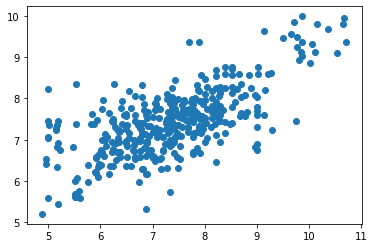

In [163]:
plt.scatter(y_test, y_pred)

## 일단 우리 모델이 어느정도 잘 작동하는 것 같다! 

## 그림을 조금 더 예쁘게 그려봅시다. 

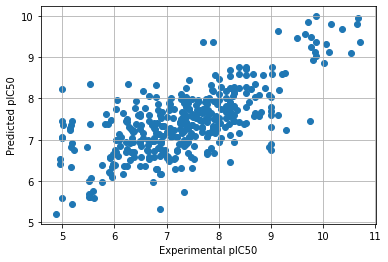

In [164]:
plt.scatter(y_test, y_pred)
plt.xlabel("Experimental pIC50")
plt.ylabel("Predicted pIC50")
plt.grid()


## 기준선 (y==x), 완벽한 예측의 경우, 를 추가해서 그려보자

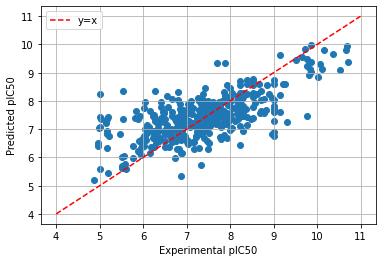

In [165]:
plt.scatter(y_test, y_pred)
plt.xlabel("Experimental pIC50")
plt.ylabel("Predicted pIC50")
plt.grid()
plt.plot(range(4, 12), range(4, 12), "r--", label = "y=x")
plt.legend()

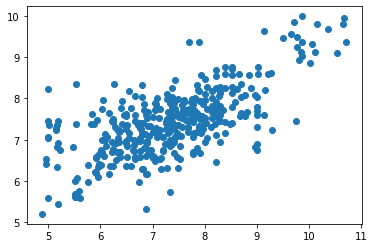

In [166]:
plt.plot(y_test, y_pred, "o")

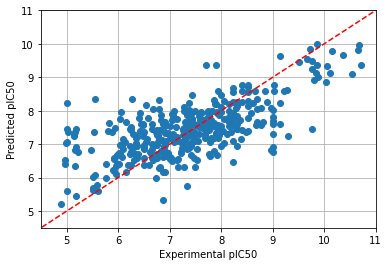

In [167]:
plt.plot(y_test, y_pred, "o")
plt.plot(range(4, 12), range(4, 12), 'r--')
plt.xlabel("Experimental pIC50")
plt.ylabel("Predicted pIC50")
plt.xlim(4.5, 11)
plt.ylim(4.5, 11)
plt.grid()

## 오차를 정량화 해보자!

* regression에서 가장 많이 사용하는 측정치는 mean squared error 이다. 
* 평균 제곱 오차

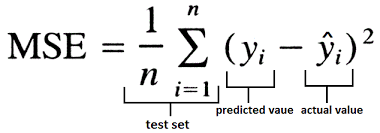

In [168]:
from sklearn.metrics import mean_squared_error

### 오차 계산!

In [169]:
mse1 = mean_squared_error(y_test, y_pred)

In [170]:
import math

In [171]:
math.sqrt(mean_squared_error(y_test, y_pred))

0.8446100341207292

In [172]:
mse1

0.7133661097374193

# 더 나은 모델을 만들어보자!

## 트리의 개수를 늘린 모델을 학습시켜보자!

In [173]:
my_model_v2 = RandomForestRegressor(n_estimators = 200)

In [174]:
my_model_v2.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200)

In [175]:
y_pred_v2 = my_model_v2.predict(X_test)

In [176]:
mse2 = mean_squared_error(y_test, y_pred_v2)

In [177]:
print(mse2)

0.7061327365635488


In [178]:
print(mse1, mse2)

0.7133661097374193 0.7061327365635488


# 더 좋은 결과를 얻었다!!

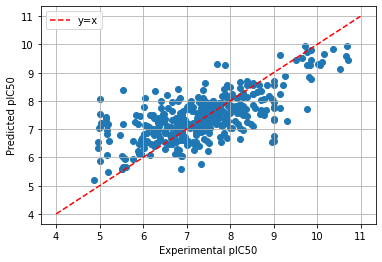

In [179]:
plt.scatter(y_test, y_pred_v2)
plt.xlabel("Experimental pIC50")
plt.ylabel("Predicted pIC50")
plt.grid()
plt.plot(range(4, 12), range(4, 12), "r--", label = "y=x")
plt.legend()

# Tree 개수 300개에 도전!

In [180]:
my_model_v3 = RandomForestRegressor(n_estimators = 300)

In [181]:
my_model_v3.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300)

In [182]:
y_pred_v3 = my_model_v3.predict(X_test)

In [183]:
mse3 = mean_squared_error(y_test, y_pred_v3)

In [184]:
print(mse3)

0.6986596215465163


## 에러가 조금 증가했다!
* 트리 개수를 늘리는 것이 항상 모델의 정확도를 향상시키지는 않는다!

# Feature Importance 확인. 

In [185]:
my_model_v3.feature_importances_

array([0.16170595, 0.18262529, 0.08766202, 0.04751791, 0.1810906 ,
       0.06277951, 0.0266011 , 0.19372321, 0.05629442])

* 위 feature importance 결과에서 보면 0.19 값이 가장 크다!
* 8번째 특징이 분자와 JAK2 단백질 사이의 상호작용을 예측하는데 가장 중요한 역할을 한다!

In [186]:
new_data

,MW,LogP,HBA,HBD,CSP3,NumRotBond,NumRings,TPSA,NumAromaticRings,pIC50
0,367.044919,4.1591,5,1,0.000000,4,4,71.95,4,4.26
1,506.126768,3.6743,10,4,0.083333,7,5,149.78,5,4.34
2,317.173942,1.5361,6,4,0.529412,5,3,101.37,2,4.53
3,301.190260,0.9510,6,5,0.500000,5,3,98.96,2,4.56
4,294.093917,3.2130,4,2,0.062500,2,3,49.84,3,4.59
...,...,...,...,...,...,...,...,...,...,...
1906,350.185509,2.8328,7,2,0.368421,3,4,86.80,3,10.72
1907,541.294742,2.8090,11,2,0.615385,7,5,123.24,3,10.76
1908,421.214761,1.7945,8,2,0.700000,6,4,102.42,0,10.78
1909,358.121195,1.4657,8,2,0.312500,4,4,103.87,3,10.97


* 가장 중요한 성질(8번째 특징): TPSA -> polar surface area. 
* 2번째 중요한 성질: logP
* 3번째 중요한 성질: fraction of SP3 carbon. 
* 4번째 중요한 성질: Molecular weight. 

## 예제: MorganFingerprint를 feature로 사용하여 모델을 학습시켜 보자.

In [187]:
from rdkit.Chem import AllChem
fp_list = []
for idx, smiles in enumerate(data["SMILES"]): # Smiles 열에서 반복.
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits = 128)
    fp_list.append(fp)

In [188]:
import sys
fp_bit_list = []
for fp in fp_list:
  fp_bit_list.append([int(x) for x in fp.ToBitString()])

DataFrame에 넣기 위한 Dictionary를 만들어보자. 

In [189]:
dic = {}
for idx in range(128):
  key = "F" + str(idx)
  dic[key] = []

for fp in fp_bit_list:
  for idx in range(128):
    key = "F" + str(idx)
    dic[key].append(fp[idx])


In [190]:
print(dic)

{'F0': [1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [191]:
fp_data = pd.DataFrame(dic)

In [192]:
fp_data

,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F118,F119,F120,F121,F122,F123,F124,F125,F126,F127
0,1,1,0,0,0,1,0,0,1,0,...,1,0,0,1,1,0,0,0,0,1
1,1,0,1,0,0,0,1,0,1,0,...,0,1,0,1,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,1,1,1,1,1,1,1,0,1
3,0,0,0,0,0,1,0,0,0,0,...,0,1,1,1,1,1,0,1,0,1
4,1,1,0,0,0,1,0,0,1,0,...,1,0,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1906,1,0,0,0,1,1,1,0,1,0,...,1,1,0,1,1,1,1,1,0,1
1907,1,0,0,0,1,1,1,0,1,0,...,1,1,0,1,1,1,1,0,1,1
1908,0,1,1,0,0,0,0,1,0,0,...,0,0,0,0,1,1,0,0,0,0
1909,1,0,0,0,0,1,1,0,1,0,...,1,1,0,0,1,1,1,0,0,1


In [193]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(fp_data, y, test_size=0.2, random_state=42)

In [194]:
print(X_test)

      F0  F1  F2  F3  F4  F5  F6  F7  F8  F9  ...  F118  F119  F120  F121  \
1228   0   1   1   0   0   0   0   1   0   0  ...     0     0     1     0   
111    1   0   1   1   0   0   1   0   1   1  ...     0     0     0     1   
1844   1   1   0   0   1   1   0   1   1   0  ...     0     1     0     0   
1335   0   1   1   1   0   1   1   0   1   0  ...     0     0     1     0   
415    0   0   1   0   0   0   1   0   1   0  ...     1     1     0     0   
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...   ...   ...   ...   ...   
1839   1   0   0   0   1   1   1   0   1   0  ...     1     1     0     0   
733    1   1   1   1   0   1   0   1   1   0  ...     0     1     0     1   
584    1   0   1   0   0   0   0   0   0   0  ...     1     1     0     0   
812    1   0   0   1   0   0   1   0   1   1  ...     0     0     0     0   
141    1   0   0   0   0   0   0   0   1   0  ...     1     0     0     0   

      F122  F123  F124  F125  F126  F127  
1228     1     1     0     0    

In [195]:
my_model2 = RandomForestRegressor()

In [196]:
my_model2.fit(X_train, y_train)

RandomForestRegressor()

In [197]:
y_pred = my_model2.predict(X_test)

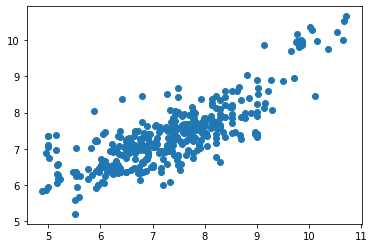

In [198]:
plt.scatter(y_test, y_pred)

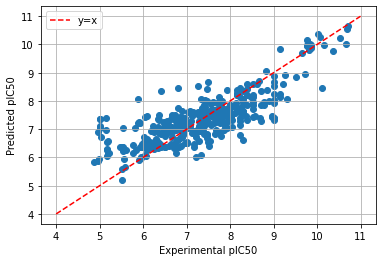

In [199]:
plt.scatter(y_test, y_pred)
plt.xlabel("Experimental pIC50")
plt.ylabel("Predicted pIC50")
plt.grid()
plt.plot(range(4, 12), range(4, 12), "r--", label = "y=x")
plt.legend()

In [200]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.3f}")

Mean Squared Error: 0.475


## Feature importance 확인
------

In [201]:
my_model2.feature_importances_

array([0.0021376 , 0.00493299, 0.00589909, 0.00569519, 0.00334249,
       0.01147521, 0.02028913, 0.01632365, 0.00726002, 0.00335874,
       0.00377228, 0.00488678, 0.0051543 , 0.00312516, 0.00626324,
       0.00692649, 0.00970899, 0.00415693, 0.00354502, 0.00444175,
       0.01132888, 0.00542674, 0.00380222, 0.00812523, 0.00376323,
       0.00477861, 0.00383301, 0.00592786, 0.01151368, 0.00427995,
       0.01609071, 0.00293036, 0.00308888, 0.00443755, 0.00290044,
       0.00333682, 0.00647398, 0.0044382 , 0.00810747, 0.00536076,
       0.00467719, 0.01149309, 0.00242259, 0.0066747 , 0.00750989,
       0.00559064, 0.00693885, 0.00551586, 0.00318969, 0.00449239,
       0.01066234, 0.00650984, 0.0049627 , 0.00584211, 0.00547466,
       0.00789267, 0.00366446, 0.00300382, 0.00877052, 0.00298395,
       0.00852793, 0.00340358, 0.00307821, 0.00545729, 0.0054742 ,
       0.00588398, 0.00824194, 0.0083453 , 0.00597491, 0.03318843,
       0.00726763, 0.01174969, 0.00508805, 0.00702983, 0.00442

몇 번째 element가 가장 큰 값을 가지는지 확인해보자. 

In [202]:
np.argmax(my_model2.feature_importances_)

124

F124가 가장 중요한 feature이다!

# 연습1: fingerprint의 bit를 1024로 늘려서 학습시켜 보자. 

In [206]:
from rdkit.Chem import AllChem
fp_list = []
for idx, smiles in enumerate(data["SMILES"]): # Smiles 열에서 반복.
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits = 1024)
    fp_list.append(fp)

import sys
fp_bit_list = []
for fp in fp_list:
  fp_bit_list.append([int(x) for x in fp.ToBitString()])

dic = {}
for idx in range(1024):
  key = "F" + str(idx)
  dic[key] = []

for fp in fp_bit_list:
  for idx in range(1024):
    key = "F" + str(idx)
    dic[key].append(fp[idx])

fp_data = pd.DataFrame(dic)

In [207]:
fp_data

,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F1014,F1015,F1016,F1017,F1018,F1019,F1020,F1021,F1022,F1023
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1906,0,0,0,0,1,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
1907,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,0
1908,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1909,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [208]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(fp_data, y, test_size=0.2, random_state=42)

In [209]:
my_model_1024 = RandomForestRegressor()
my_model_1024.fit(X_train, y_train)

RandomForestRegressor()

In [211]:
y_pred = my_model_1024.predict(X_test)

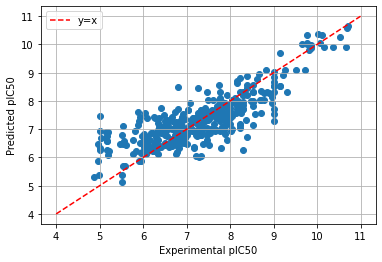

In [212]:
plt.scatter(y_test, y_pred)
plt.xlabel("Experimental pIC50")
plt.ylabel("Predicted pIC50")
plt.grid()
plt.plot(range(4, 12), range(4, 12), "r--", label = "y=x")
plt.legend()

In [213]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.3f}")

Mean Squared Error: 0.424


In [215]:
np.argmax(my_model_1024.feature_importances_)

124

# 연습2: descriptor와 fingerprint를 합친 모델을 학습시켜보자. 

In [217]:
new_data

,MW,LogP,HBA,HBD,CSP3,NumRotBond,NumRings,TPSA,NumAromaticRings,pIC50
0,367.044919,4.1591,5,1,0.000000,4,4,71.95,4,4.26
1,506.126768,3.6743,10,4,0.083333,7,5,149.78,5,4.34
2,317.173942,1.5361,6,4,0.529412,5,3,101.37,2,4.53
3,301.190260,0.9510,6,5,0.500000,5,3,98.96,2,4.56
4,294.093917,3.2130,4,2,0.062500,2,3,49.84,3,4.59
...,...,...,...,...,...,...,...,...,...,...
1906,350.185509,2.8328,7,2,0.368421,3,4,86.80,3,10.72
1907,541.294742,2.8090,11,2,0.615385,7,5,123.24,3,10.76
1908,421.214761,1.7945,8,2,0.700000,6,4,102.42,0,10.78
1909,358.121195,1.4657,8,2,0.312500,4,4,103.87,3,10.97


In [218]:
new_data_X = new_data.iloc[:, :-1] # 전체행, 마지막열 직전까지.
y = new_data.iloc[:, -1] # 전체행, 마지막열의 데이터를 추출.

In [219]:
new_data_X

,MW,LogP,HBA,HBD,CSP3,NumRotBond,NumRings,TPSA,NumAromaticRings
0,367.044919,4.1591,5,1,0.000000,4,4,71.95,4
1,506.126768,3.6743,10,4,0.083333,7,5,149.78,5
2,317.173942,1.5361,6,4,0.529412,5,3,101.37,2
3,301.190260,0.9510,6,5,0.500000,5,3,98.96,2
4,294.093917,3.2130,4,2,0.062500,2,3,49.84,3
...,...,...,...,...,...,...,...,...,...
1906,350.185509,2.8328,7,2,0.368421,3,4,86.80,3
1907,541.294742,2.8090,11,2,0.615385,7,5,123.24,3
1908,421.214761,1.7945,8,2,0.700000,6,4,102.42,0
1909,358.121195,1.4657,8,2,0.312500,4,4,103.87,3


In [220]:
fp_data

,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F1014,F1015,F1016,F1017,F1018,F1019,F1020,F1021,F1022,F1023
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1906,0,0,0,0,1,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
1907,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,0
1908,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1909,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [221]:
X=pd.concat([new_data_X,fp_data], axis=1)
X

,MW,LogP,HBA,HBD,CSP3,NumRotBond,NumRings,TPSA,NumAromaticRings,F0,...,F1014,F1015,F1016,F1017,F1018,F1019,F1020,F1021,F1022,F1023
0,367.044919,4.1591,5,1,0.000000,4,4,71.95,4,0,...,0,0,0,0,0,0,0,0,0,0
1,506.126768,3.6743,10,4,0.083333,7,5,149.78,5,0,...,0,0,0,0,0,0,0,0,0,0
2,317.173942,1.5361,6,4,0.529412,5,3,101.37,2,0,...,0,0,0,0,0,1,0,0,0,0
3,301.190260,0.9510,6,5,0.500000,5,3,98.96,2,0,...,0,0,0,0,0,1,0,0,0,0
4,294.093917,3.2130,4,2,0.062500,2,3,49.84,3,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1906,350.185509,2.8328,7,2,0.368421,3,4,86.80,3,0,...,0,0,0,1,0,1,0,0,0,0
1907,541.294742,2.8090,11,2,0.615385,7,5,123.24,3,0,...,0,0,0,0,1,1,0,0,0,0
1908,421.214761,1.7945,8,2,0.700000,6,4,102.42,0,0,...,0,0,0,0,0,1,0,0,0,0
1909,358.121195,1.4657,8,2,0.312500,4,4,103.87,3,0,...,0,0,0,0,0,1,0,0,0,0


In [222]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [223]:
my_model_multi = RandomForestRegressor()
my_model_multi.fit(X_train, y_train)

RandomForestRegressor()

In [224]:
y_pred = my_model_multi.predict(X_test)

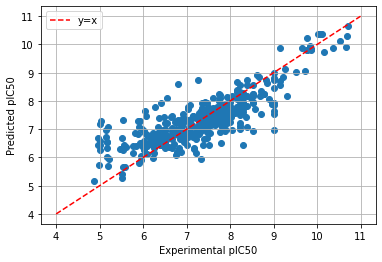

In [225]:
plt.scatter(y_test, y_pred)
plt.xlabel("Experimental pIC50")
plt.ylabel("Predicted pIC50")
plt.grid()
plt.plot(range(4, 12), range(4, 12), "r--", label = "y=x")
plt.legend()


In [226]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.3f}")

Mean Squared Error: 0.415


In [227]:
np.argmax(my_model_multi.feature_importances_)

133

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install catboost
!pip install NGboost
import catboost as cb
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import preprocessing
import seaborn as sns

In [243]:
num_folds= 10
seed = 7
scoring = 'neg_mean_squared_error'

models = []
models.append(('LR',LinearRegression()))
models.append(('LASSO',Lasso()))
models.append(('KNN',KNeighborsRegressor()))
models.append(('CART',DecisionTreeRegressor()))
models.append(('EN',ElasticNet()))
models.append(('SVM',SVR()))
models.append(('RFR',RandomForestRegressor()))
models.append(('XGBR',XGBRegressor(objective='reg:squarederror')))
models.append(('LGBMR',LGBMRegressor()))
models.append(('CatBR',CatBoostRegressor( silent=True)))
models.append(('AdaR',AdaBoostRegressor()))

results =[]
names = []
for name, model in models:
  kfold = KFold(n_splits=10,random_state=7,shuffle = True)
  cv_results = cross_val_score(model,X_train,y_train
                               ,cv= kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s : %f (%f) "%(name,-cv_results.mean(),cv_results.std())
  print(msg)

LR : 8.955603 (2.514406) 
LASSO : 1.278297 (0.145131) 
KNN : 1.242570 (0.161871) 
CART : 0.814785 (0.145635) 
EN : 1.276955 (0.145942) 
SVM : 1.244693 (0.142055) 
RFR : 0.466201 (0.089380) 
XGBR : 0.565720 (0.078288) 
LGBMR : 0.474564 (0.101592) 
CatBR : 0.443332 (0.076973) 
AdaR : 0.860480 (0.083793) 


In [244]:
model_RF=RandomForestRegressor()
model_RF.fit(X_train,y_train)

model_cat=CatBoostRegressor(silent=True)
model_cat.fit(X_train,y_train)

model_lgb=LGBMRegressor()
model_lgb.fit(X_train,y_train)

pred=model_RF.predict(X_test)
pred2=model_cat.predict(X_test)
pred3=model_lgb.predict(X_test)

# pred_fin=np.expm1(pred)
pred_fin= (pred+pred2+pred3)/3
pred_fin=pd.DataFrame(pred_fin)

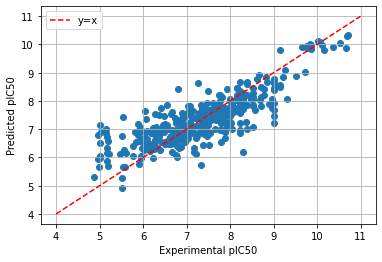

In [245]:
plt.scatter(y_test, pred_fin)
plt.xlabel("Experimental pIC50")
plt.ylabel("Predicted pIC50")
plt.grid()
plt.plot(range(4, 12), range(4, 12), "r--", label = "y=x")
plt.legend()


In [246]:
mse = mean_squared_error(y_test, pred_fin)
print(f"Mean Squared Error: {mse:.3f}")

Mean Squared Error: 0.403
